# Tiny ImageNet: Visualize Layers

Similar to the *kernel_viz.ipynb* notebook, but attempts visualize after the 4th convolution (before the 2nd max-pool operation). Again, many common filter patterns are seen, but in general the results are noiser. The colors seem dominated by blues and oranges, which I don't have a good explanation for.

These results exhibit [Checkerboard Artifacts](http://distill.pub/2016/deconv-checkerboard/).

Python Notebook by Patrick Coady: [Learning Artificial Intelligence](https://pat-coady.github.io/)

In [1]:
from train import *
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
class TrainConfig(object):
    """Training configuration"""
    dropout_keep_prob = 1.0
    model_name = 'vgg_16'  # choose model 
    model = staticmethod(globals()[model_name])
    config_name = 'baseline'  # choose training run

In [3]:
def img_grad(config):
    """find gradient from pixel to img"""
    with tf.Graph().as_default():
        g = tf.get_default_graph()
        img = tf.Variable(np.zeros((1, 56, 56, 3), dtype=np.uint8) + 128,
                           trainable=False,
                           dtype=tf.uint8,
                         collections=[tf.GraphKeys.LOCAL_VARIABLES])
        logits = config.model(img, config)
        pixels = g.get_tensor_by_name('conv2_2/BiasAdd:0')
        float_img = g.get_tensor_by_name('Cast:0')
        grads = []
        for i in range(64):
            grads.append(tf.gradients(pixels[0, 14, 14, i], float_img))
        saver = tf.train.Saver()
        init = tf.group(tf.global_variables_initializer(),
                    tf.local_variables_initializer())
        with tf.Session() as sess:
            init.run()
            path = 'checkpoints/' + config.model_name + '/' + config.config_name
            saver.restore(sess, tf.train.latest_checkpoint(path))
            results = sess.run(grads)
      
    return results

In [4]:
config = TrainConfig()
result = img_grad(config)

INFO:tensorflow:Restoring parameters from checkpoints/vgg_16/baseline/model-42000


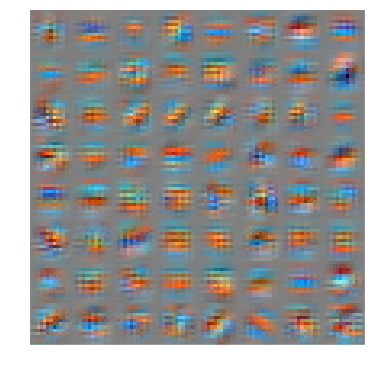

In [5]:
composite = np.zeros((13*8, 13*8, 3), dtype=np.uint8)
for i in range(8):
    for j in range(8):
        idx = i * 8 + j
        crop = np.squeeze(result[idx])[22:35, 22:35, :]
        crop = crop / np.max([-np.min(crop), np.max(crop)])
        crop = (crop * 127 + 128).astype(np.uint8)
        composite[(i*13):(i*13+13), (j*13):(j*13+13), :] = crop
        
plt.imshow(composite, interpolation='none')
plt.axis('off')
plt.show()